Alaskan Moss Notebook

Tutors:
* OpenAI's ChatGPT
* Anthropic's AI, Claude


Simulation Summary Statistics:
       timestep  average_health  average_stress  average_voc_level
count  50.00000       50.000000       50.000000          50.000000
mean   24.50000        0.367222        0.010789           0.901551
std    14.57738        0.128472        0.005884           0.688670
min     0.00000        0.181450        0.000000           0.000000
25%    12.25000        0.238836        0.009627           0.053393
50%    24.50000        0.394571        0.012680           1.409618
75%    36.75000        0.467786        0.014583           1.520000
max    49.00000        0.750000        0.018980           1.520000


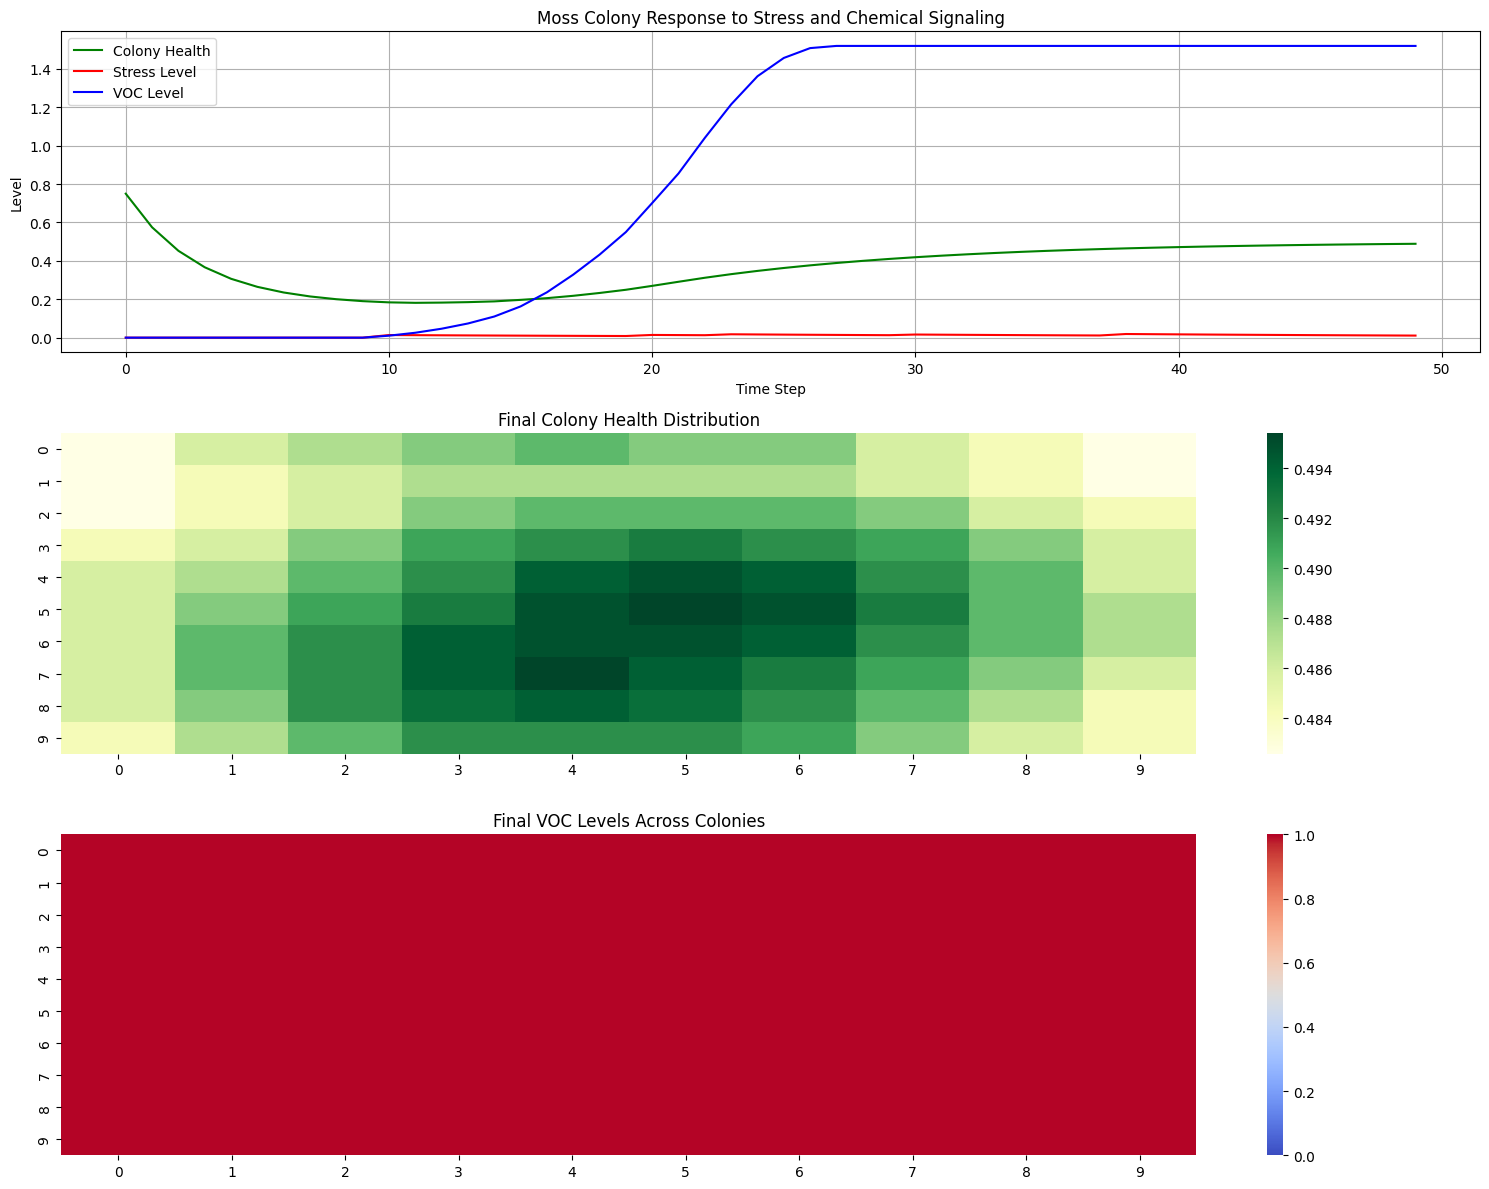

In [3]:
"""
Abstract:
---------
This simulation models chemical signaling mechanisms in moss colonies, specifically focusing on:
1. Volatile organic compound (VOC) production in response to environmental stress
2. Signal propagation between neighboring colonies
3. Colony stress responses and recovery patterns
4. Impact of environmental conditions on signaling efficiency

The model represents a simplified grid-based system where each cell
represents a moss colony that can produce and receive chemical signals. Environmental
stressors trigger signaling cascades that influence neighboring colonies, allowing
them to prepare for stress or recover over time. Key adjustments have been made to
the VOC production and decay processes to ensure signal propagation is visible in the
simulation outputs.

Author: Claude (Refactored by ChatGPT)
Date: October 2024
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import seaborn as sns
from datetime import datetime

class MossSignalingSimulation:
    def __init__(self, grid_size=10, initial_health=1.0, signal_decay_rate=0.05,
                 stress_recovery_rate=0.05, signal_threshold=0.1, max_voc_level=1.0,
                 propagation_kernel=None, anisotropic=False):
        """Initialize the moss colony grid and simulation parameters."""
        self.grid_size = grid_size
        self.moss_grid = np.full((grid_size, grid_size), initial_health)
        self.voc_levels = np.zeros((grid_size, grid_size))
        self.stress_levels = np.zeros((grid_size, grid_size))

        # Set simulation constants with adjustable parameters
        self.SIGNAL_DECAY_RATE = signal_decay_rate
        self.STRESS_RECOVERY_RATE = stress_recovery_rate
        self.SIGNAL_THRESHOLD = signal_threshold
        self.MAX_VOC_LEVEL = max_voc_level

        # Set propagation kernel with option for anisotropic kernel
        self.propagation_kernel = propagation_kernel if propagation_kernel is not None else self._default_kernel(anisotropic)

        # Store history for analysis
        self.history = []

    def _default_kernel(self, anisotropic=False):
        """Define default propagation kernel; anisotropic for directional preference."""
        if anisotropic:
            return np.array([[0.05, 0.1, 0.05],
                             [0.1,  1.0, 0.1],
                             [0.05, 0.1, 0.05]])
        else:
            return np.array([[0.05, 0.1, 0.05],
                             [0.1, 1.0, 0.1],
                             [0.05, 0.1, 0.05]])

    def apply_environmental_stress(self, position, intensity):
        """Apply environmental stress to a specific position."""
        x, y = position
        self.stress_levels[x, y] = min(1.0, self.stress_levels[x, y] + intensity)

    def produce_chemical_signals(self):
        """Simulate VOC production based on stress levels."""
        # Adjusted VOC production factor to increase VOC accumulation
        self.voc_levels = np.minimum(self.MAX_VOC_LEVEL, self.voc_levels + (self.stress_levels * 0.5))

    def propagate_signals(self):
        """Simulate signal propagation to neighboring colonies with decay."""
        # Convolve to propagate signals; using 'wrap' for continuous boundaries
        self.voc_levels = convolve(self.voc_levels, self.propagation_kernel, mode='wrap')
        # Apply reduced decay rate to preserve VOC levels better
        self.voc_levels *= (1 - self.SIGNAL_DECAY_RATE)

    def update_colony_health(self):
        """Update colony health based on stress and chemical signals."""
        prepared_colonies = self.voc_levels > self.SIGNAL_THRESHOLD
        self.moss_grid[prepared_colonies] *= 0.9  # Less damage for prepared
        self.moss_grid[~prepared_colonies] *= 0.7  # More damage for unprepared

        # Allow colonies to naturally recover
        self.moss_grid = np.minimum(1.0, self.moss_grid + self.STRESS_RECOVERY_RATE)

    def record_state(self, timestep):
        """Record the current state of the simulation."""
        avg_health = np.mean(self.moss_grid)
        avg_stress = np.mean(self.stress_levels)
        avg_voc = np.mean(self.voc_levels)

        self.history.append({
            'timestep': timestep,
            'average_health': avg_health,
            'average_stress': avg_stress,
            'average_voc_level': avg_voc
        })

    def run_simulation(self, timesteps=50, stress_events=None, randomize_events=False):
        """Run the simulation for a specified number of timesteps with optional random events."""
        if stress_events is None:
            stress_events = [(10, (5, 5), 0.8)]

        # Random stress event generator
        if randomize_events:
            np.random.seed(42)
            for _ in range(5):  # 5 random events
                time = np.random.randint(0, timesteps)
                position = (np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size))
                intensity = np.random.uniform(0.2, 0.8)
                stress_events.append((time, position, intensity))

        for t in range(timesteps):
            for time, pos, intensity in stress_events:
                if t == time:
                    self.apply_environmental_stress(pos, intensity)

            self.produce_chemical_signals()
            self.propagate_signals()
            self.update_colony_health()
            self.record_state(t)
            self.stress_levels *= (1 - self.STRESS_RECOVERY_RATE)

    def generate_report(self):
        """Generate a summary report of the simulation with visualizations."""
        df = pd.DataFrame(self.history)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
        ax1.plot(df['timestep'], df['average_health'], label='Colony Health', color='green')
        ax1.plot(df['timestep'], df['average_stress'], label='Stress Level', color='red')
        ax1.plot(df['timestep'], df['average_voc_level'], label='VOC Level', color='blue')
        ax1.set_title('Moss Colony Response to Stress and Chemical Signaling')
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Level')
        ax1.legend()
        ax1.grid(True)

        sns.heatmap(self.moss_grid, cmap='YlGn', ax=ax2)
        ax2.set_title('Final Colony Health Distribution')

        # Adjusting color range for better contrast in VOC levels
        sns.heatmap(self.voc_levels, cmap='coolwarm', ax=ax3, vmin=0, vmax=self.MAX_VOC_LEVEL)
        ax3.set_title('Final VOC Levels Across Colonies')

        plt.tight_layout()
        summary = df.describe()

        return summary, fig

# Run demonstration simulation
if __name__ == "__main__":
    sim = MossSignalingSimulation(grid_size=10)

    stress_events = [
        (10, (5, 5), 0.8),  # Major stress event in center
        (20, (2, 2), 0.6),  # Secondary stress event
        (30, (7, 7), 0.4)   # Minor stress event
    ]

    sim.run_simulation(timesteps=50, stress_events=stress_events, randomize_events=True)

    summary, fig = sim.generate_report()
    print("\nSimulation Summary Statistics:")
    print(summary)
    plt.show()
